## import some pkgs and fns

In [1]:
import os
import sys
sys.path.append("../mypkg")

In [2]:
import pickle
import scipy
import torch
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr

from tqdm import trange, tqdm
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from functools import partial
from easydict import EasyDict as edict
from pathlib import Path

In [3]:
import importlib
#import constants
#importlib.reload(constants)

from utils.misc import meg_psd2spatialfeature, get_mode, load_pkl, save_pkl
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from sgm.sgm import SGM
from spectrome import Brain

from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

### some fns

In [4]:
def _simulate_data(params, sgmmodel, noise_sd=0):
    """The function to simulate samples
    """
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    psd = psd[:68, :]
    
    std_psd_DB = psd_2tr(psd).flatten()
    noises = np.random.randn(*std_psd_DB.shape)*noise_sd
    
    return std_psd_DB+noises

## Load data

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


In [6]:
# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

prior = sutils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))

In [7]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

## Simulate data

In [17]:
_simulate_data_sp = partial(_simulate_data, sgmmodel=sgmmodel, noise_sd=0)
_simulator_wrapper, prior = prepare_for_sbi(_simulate_data_sp, prior)
theta, x = simulate_for_sbi(_simulator_wrapper, prior,
                                    num_simulations=10000,
                                    num_workers=50)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [53]:
save_pkl(RES_ROOT/"simu_sps_umap.pkl", x.numpy())

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/notebooks/../mypkg/../results/simu_sps_umap.pkl


## Analysis

In [8]:
cols = ["dodgerblue", "coral"]

In [15]:
# simu data
simu_data = load_pkl(RES_ROOT/"simu_sps_umap.pkl")
reducer = umap.UMAP(random_state=2022)
reducer.fit(simu_data)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/notebooks/../mypkg/../results/simu_sps_umap.pkl


/opt/conda/lib/python3.9/site-packages/umap/spectral.py:348: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP(random_state=2022, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [16]:
reduced_simu_data = reducer.transform(simu_data)
# real data
flat_ind_psd = np.array([psd_2tr(ind_psd[:, :, ix]).flatten() for ix in range(36)])
reduced_real_data = reducer.transform(flat_ind_psd)

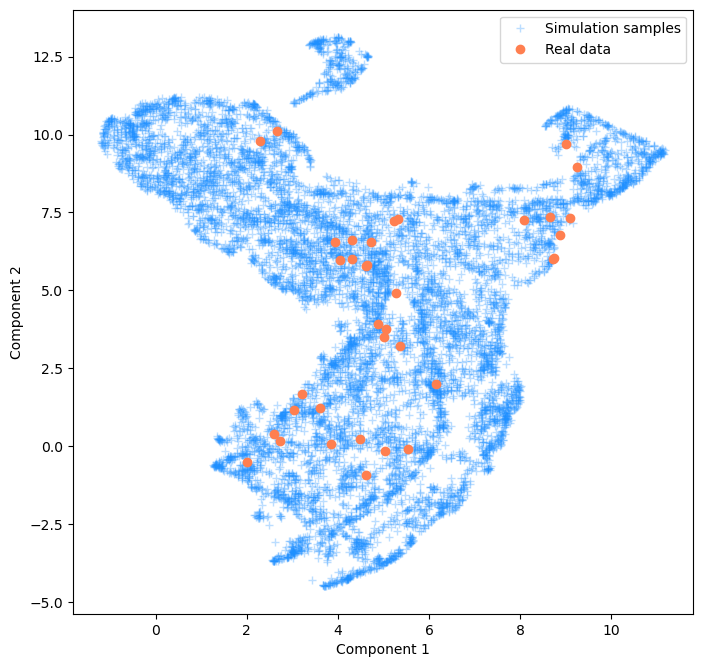

In [17]:
plt.figure(figsize=[8, 8], dpi=100)
plt.plot(reduced_simu_data[:, 0], reduced_simu_data[:, 1], "+", 
         alpha=0.3,
         color=cols[0], 
         label="Simulation samples")
plt.plot(reduced_real_data[:, 0], reduced_real_data[:, 1], "o", 
         color=cols[1], 
         label="Real data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
#plt.savefig(FIG_ROOT/"umap.jpg",  bbox_inches='tight')